<a href="https://colab.research.google.com/github/timothy-voiuhy/WasteClassification/blob/main/WasteClassificationv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 14.4 MB/s eta 0:00:00


In [ ]:
# some necessary imports
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import torch.nn as nn
import seaborn as sns
from torch.utils.data import random_split,  Dataset, DataLoader
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import os
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import shutil
import os

In [ ]:
# download the waste data.
!kaggle datasets download -d alistairking/recyclable-and-household-waste-classification

Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification
License(s): MIT
 98% 903M/920M [00:05<00:00, 208MB/s]
100% 920M/920M [00:05<00:00, 167MB/s]


In [ ]:
# !unzip recyclable-and-household-waste-classification.zip
!ls

images	README.txt  recyclable-and-household-waste-classification.zip  sample_data


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
DATA_DIR_PATH = "images/images/"
bestModelPath = "/content/drive/MyDrive/Models/WasteClfBest.pt"
bestModelPathC = "/content/drive/MyDrive/Models/WasteClfBest0.pt"
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
odd_nums = [num for num in range(1, 501) if num % 2 != 0]
even_nums = [num for num in range(1, 501) if num%2 == 0]
def MergeData():
    dirs = []
    for __dir_name in os.listdir(DATA_DIR_PATH):
        dirs.append(os.path.join(DATA_DIR_PATH, __dir_name))
    for __dir in dirs:
        default_dir = __dir+"/default"
        real_world_dir = __dir+"/real_world"
        for __d_filename, __r_filename, __e, __o in zip(os.listdir(default_dir), os.listdir(real_world_dir), even_nums, odd_nums):
            _d__filename = os.path.join(__dir, __d_filename.split("_")[0]+"_"+str(__o)+".png")
            _r__filename = os.path.join(__dir, __r_filename.split("_")[0]+"_"+str(__e)+".png")
            shutil.move(os.path.join(default_dir, __d_filename),_d__filename)
            shutil.move(os.path.join(real_world_dir, __r_filename),_r__filename)
        os.rmdir(default_dir)
        os.rmdir(real_world_dir)
MergeData()

In [ ]:
transform = v2.Compose([
    v2.Resize(IMAGE_SIZE),
])

train_transform = v2.Compose([
    v2.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2),
    v2.ToTensor(),
    v2.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

val_test_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean = (0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset = ImageFolder(
    root = DATA_DIR_PATH,
    transform = transform
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
class CDataset(Dataset):
    def __init__(self, _dataset, transform_:v2.Compose, classes) -> None:
        super().__init__()
        self.dataset = _dataset
        self.transform = transform_
        self.classes = classes

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image)
        return image, label

    def __len__(self,):
        return len(self.dataset)

In [ ]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
validation_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - validation_size

_train_dataset, _validation_dataset, _test_dataset = random_split(dataset, [train_size, validation_size, test_size])

train_dataset = CDataset(_train_dataset, train_transform, dataset.classes)
validation_dataset = CDataset(_validation_dataset, val_test_transform, dataset.classes)
test_dataset = CDataset(_test_dataset, val_test_transform, dataset.classes)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(validation_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 10500
Validation size: 2250
Test size: 2250


In [ ]:
train_dataloader = DataLoader(train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle = True,
                        num_workers = 2)

validation_dataloader = DataLoader(validation_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle = True,
                        num_workers = 2)
test_dataloader = DataLoader(test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle = True,
                        num_workers = 2)

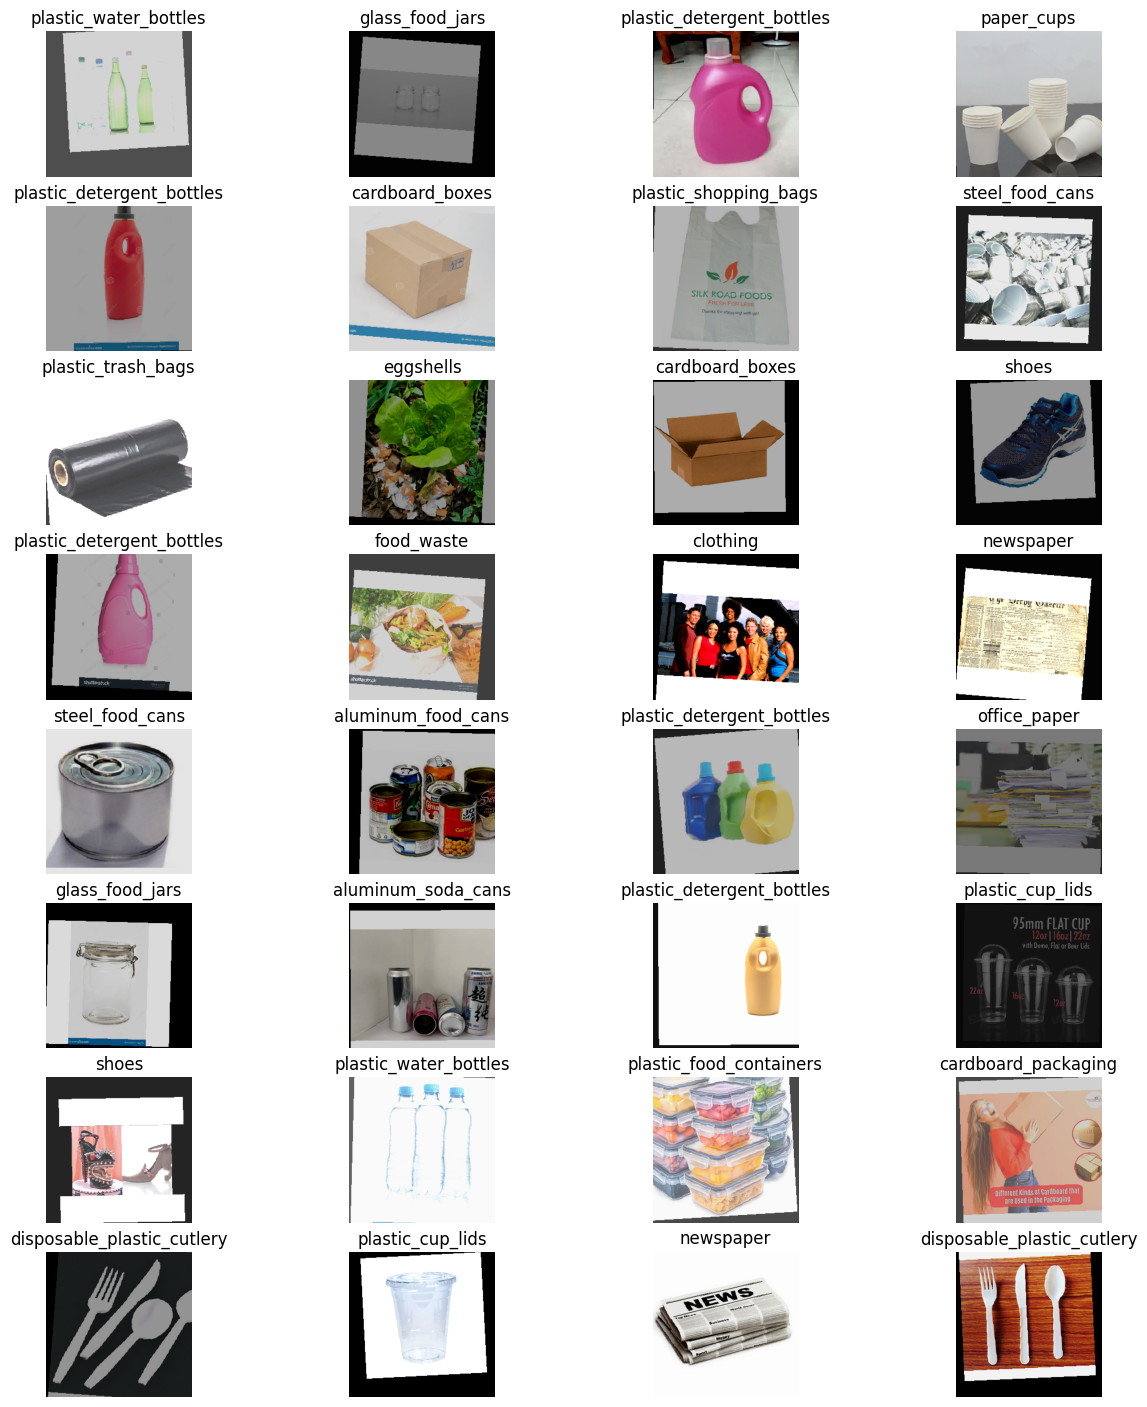

In [ ]:
images, labels = next(iter(train_dataloader))
class_names = train_dataset.classes
column_count = 4
row_count = len(images) // column_count + 1
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
plt.figure(figsize = (15, 20))
for idx, (image, label) in enumerate(zip(images, labels)):
    image  = image.cpu().numpy().transpose((1, 2, 0))
    image = std*image + mean
    plt.subplot(row_count, column_count, idx+1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")

plt.show()

In [ ]:
base_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
print(base_model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 45.7MB/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
class WasteClfModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        train_nodes, eval_nodes = get_graph_node_names(self.base_model)
        self.f_ext = create_feature_extractor(
            self.base_model,
            return_nodes={'features.12': 'base_model_ext_features'}
        )
        self.conv1 = nn.Conv2d(576,300,3)
        self.Linear1 = nn.Linear(10800,900)
        self.Linear2 = nn.Linear(900, 30)
        self.drop_out = nn.Dropout()

    def forward(self,x):
        f_layer = self.f_ext(x)['base_model_ext_features'] # pass the inputs through the mobile net model but only extract out the features at the 12 block CNN
        x = F.relu(self.conv1(f_layer))
        x = x.flatten(start_dim=1)
        x = self.drop_out(x)
        x = self.Linear1(x)
        x = self.Linear2(x)
        return x

In [ ]:
loss_fn = nn.CrossEntropyLoss()
model = WasteClfModel()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
clf_accuracy = Accuracy(task="multiclass", num_classes=30)

In [ ]:
def computeLoss(model:WasteClfModel, images, labels, train = False):
    images, labels = images.to(device), labels.to(device)
    preds = model(images)
    loss = loss_fn(preds, labels)
    if train:
        loss.backward()
    acc = clf_accuracy(preds.cpu(), labels.cpu())
    if isinstance(loss, torch.Tensor):
        loss = loss.item()
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return loss, acc

def evaluateModel(model:WasteClfModel):
    model.eval()
    with torch.inference_mode():
        total_loss = 0
        total_acc = 0
        for idx, (images, labels) in enumerate(test_dataloader):
            loss, acc = computeLoss(model, images, labels)
            total_loss += loss
            total_acc += acc
        avg_loss = total_loss / len(test_dataloader)
        avg_acc = total_acc / len(test_dataloader)
        print(f"Test Loss: {avg_loss:.5f}, Test Acc: {avg_acc:.5f}")
    return avg_loss, avg_acc

def validateModel(model:WasteClfModel):
    model.eval()
    with torch.inference_mode():
        total_loss = 0
        total_acc = 0
        for idx, (images, labels) in enumerate(validation_dataloader):
            loss, acc = computeLoss(model, images, labels)
            total_loss += loss
            total_acc += acc
        avg_loss = total_loss / len(validation_dataloader)
        avg_acc = total_acc / len(validation_dataloader)
    return avg_loss, avg_acc

def trainModel(model:WasteClfModel, epochs = 1):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    min_loss_ = 1.1244753649536992
    for epoch in range(0, epochs):
        print(f"Epoch: {epoch}")
        model.train()
        epoch_total_loss = 0
        epoch_total_acc = 0
        for idx, (images, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_loss, train_acc = computeLoss(model, images, labels, train = True)
            epoch_total_loss += train_loss
            epoch_total_acc += train_acc
            optimizer.step()

            if idx % 30 == 0:
                print(f"\tStep: {idx}/{len(train_dataloader)} Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")

        val_loss, val_acc = validateModel(model)

        train_loss = epoch_total_loss / len(train_dataloader)
        train_acc = epoch_total_acc / len(train_dataloader)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch: {epoch}, Train Loss: {train_loss:.5f}, Train Acc: {train_acc:5f}, Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
        if val_loss < min_loss_:
            print(f"Model val_loss improved from {min_loss_} to {val_loss}")
            min_loss_ = val_loss
            torch.save(model.state_dict(), bestModelPath)
            print(f"Model Saved to file: {bestModelPath}")
        else:
            print(f"Model val_loss did not improve from {min_loss_}")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [ ]:
# now its time to write the training loop
history = trainModel(model, 20)

Epoch: 0
	Step: 0/329 Train Loss: 0.71138, Train Acc: 0.71875
	Step: 30/329 Train Loss: 0.84503, Train Acc: 0.84375
	Step: 60/329 Train Loss: 0.76317, Train Acc: 0.78125
	Step: 90/329 Train Loss: 0.98122, Train Acc: 0.68750
	Step: 120/329 Train Loss: 1.06819, Train Acc: 0.71875
	Step: 150/329 Train Loss: 0.58780, Train Acc: 0.81250
	Step: 180/329 Train Loss: 1.00032, Train Acc: 0.78125
	Step: 210/329 Train Loss: 1.62672, Train Acc: 0.62500
	Step: 240/329 Train Loss: 0.86969, Train Acc: 0.81250
	Step: 270/329 Train Loss: 0.66900, Train Acc: 0.90625
	Step: 300/329 Train Loss: 0.73224, Train Acc: 0.71875
Epoch: 0, Train Loss: 0.86951, Train Acc: 0.756554, Val Loss: 1.12448, Val Acc: 0.73873
Model val_loss improved from 1.1387636061285582 to 1.1244753649536992
Model Saved to file: /content/drive/MyDrive/Models/WasteClfBest.pt
Epoch: 1
	Step: 0/329 Train Loss: 0.42190, Train Acc: 0.87500
	Step: 30/329 Train Loss: 0.95968, Train Acc: 0.71875
	Step: 60/329 Train Loss: 1.12761, Train Acc: 0.75

In [ ]:
evaluateModel(model)

Test Loss: 1.08448, Test Acc: 0.74454


(1.0844790083421787, 0.7445422536890272)

In [ ]:
torch.save(model.state_dict(), bestModelPathC)

In [ ]:
savedModel = WasteClfModel()
savedModel.load_state_dict(torch.load(bestModelPath))
savedModel.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 48.2MB/s]
<ipython-input-15-36f9da53908d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full 

WasteClfModel(
  (base_model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2):

In [ ]:
y_preds, y_true = [], []

for idx, (images_, labels_) in enumerate(test_dataloader):
    images_, labels_ = images_.to(device), labels_.to(device)
    savedModel.eval()
    with torch.inference_mode():
        output = savedModel(images_)
        preds = torch.argmax(output,1)
        if idx == 0:
            print(preds)
        y_preds.extend(preds.cpu().numpy().tolist())
        y_true.extend(labels_.cpu().numpy().tolist())

tensor([28, 28, 16, 11,  4,  7, 25, 15,  6, 22, 26, 15, 17, 11,  0, 11,  1,  8,
        22, 11,  1, 13, 17, 28, 18,  7,  4,  8,  5, 18,  4,  4],
       device='cuda:0')


In [ ]:
output.shape

torch.Size([32, 30])

In [ ]:
output.device

device(type='cuda', index=0)

In [ ]:
output = torch.argmax(output, dim=1)
output.shape

torch.Size([32])

In [ ]:
len(y_true), len(y_preds), len(class_names)

(2250, 2250, 30)

In [ ]:
print(classification_report(y_true, y_preds, target_names= class_names))

                            precision    recall  f1-score   support

              aerosol_cans       0.80      0.95      0.87        64
        aluminum_food_cans       0.49      0.86      0.62        87
        aluminum_soda_cans       0.95      0.66      0.78        59
           cardboard_boxes       0.33      0.01      0.03        69
       cardboard_packaging       0.44      0.92      0.59        65
                  clothing       0.88      0.84      0.86        61
            coffee_grounds       0.99      0.99      0.99        73
disposable_plastic_cutlery       0.99      0.95      0.97        91
                 eggshells       0.99      0.88      0.93        78
                food_waste       0.94      0.85      0.90        75
    glass_beverage_bottles       0.94      0.90      0.92        82
 glass_cosmetic_containers       0.93      0.85      0.89        84
           glass_food_jars       0.85      0.89      0.87        92
                 magazines       1.00      0.86

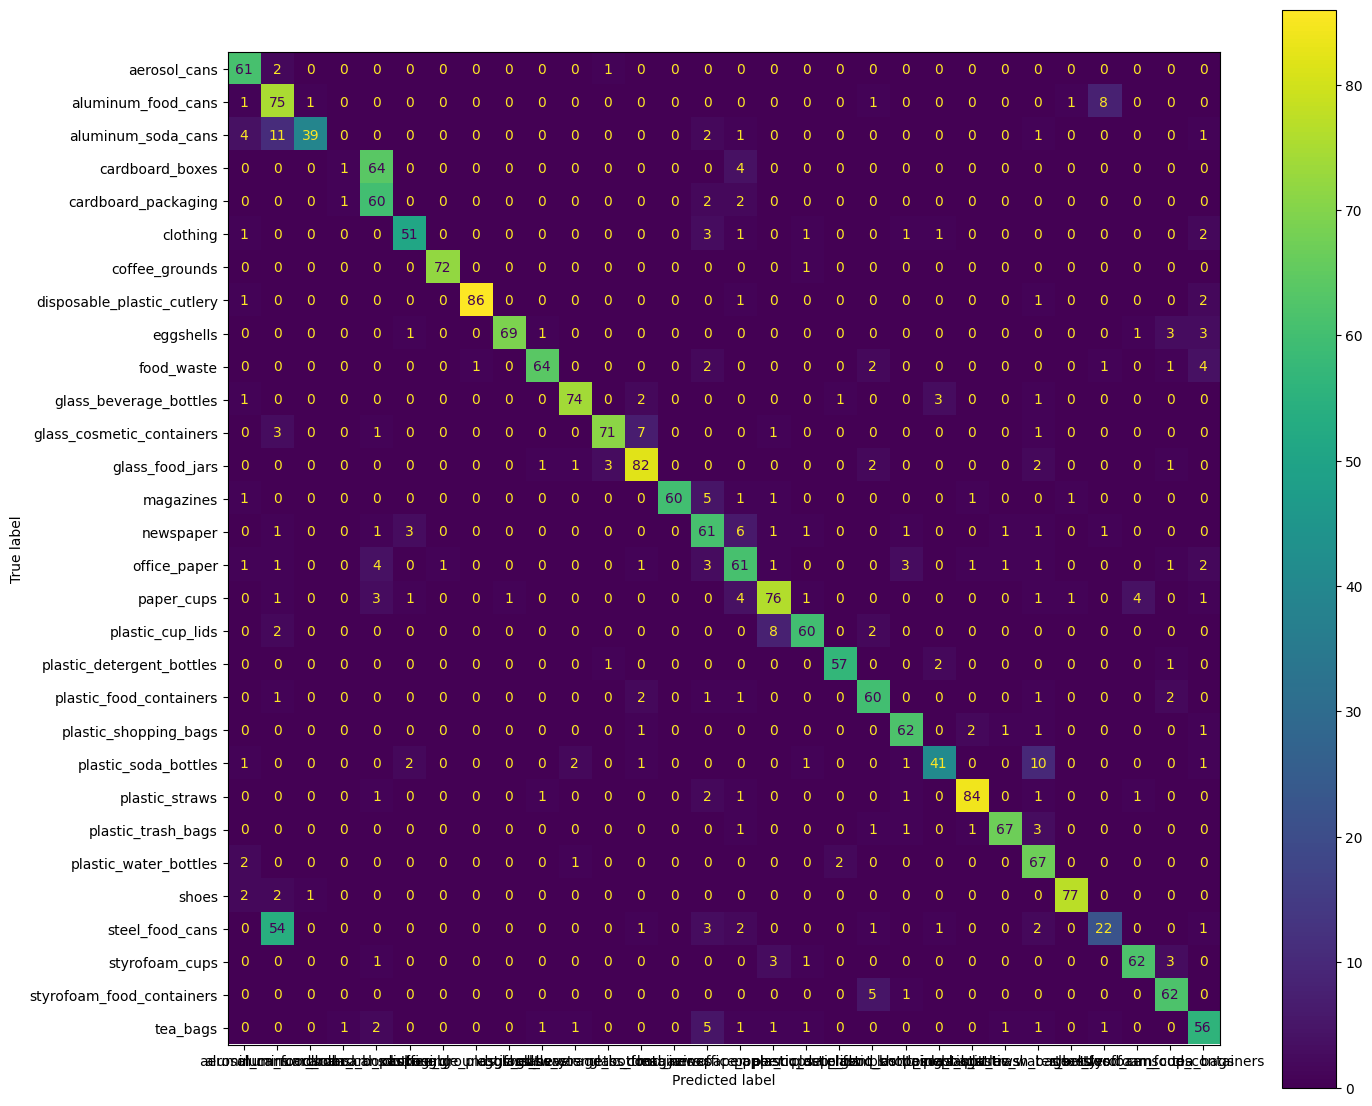

In [ ]:
cm = confusion_matrix(y_true, y_preds)
display_ = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
fig, axes = plt.subplots(figsize=(16,14))
display_.plot(ax=axes)

In [ ]:
gradcam_test_image, gradcam_test_label = next(iter(test_dataloader))[0]
plt.imshow(gradcam_test_image.permute(1, 2, 0))
plt.show()

In [ ]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
print(savedModel)

WasteClfModel(
  (base_model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2):

In [ ]:
# choosing the gradcam test image basing on what the model predicts best
gradcam_test_image = ""
gradcam_test_image_idx = ""
for images, labels in test_dataloader:
    for image, label in zip(images, labels):
        if class_names[label] == "disposable_plastic_cutlery":
            gradcam_test_image = image
            gradcam_test_image_idx = class_names.index(class_names[label])
        break

In [ ]:
# gradcam_test_image_ = gradcam_test_image.reshape((1, 3, 256, 256))
gradcam_test_image_ = gradcam_test_image.unsqueeze(0)
gradcam_test_image_.shape

torch.Size([1, 3, 256, 256])

In [ ]:
# GRADCAM
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

gradcam = GradCAM(model=savedModel, target_layer=savedModel.conv1)

output = savedModel(gradcam_test_image_.to(device))
class_idx = gradcam_test_image_idx

cam_extractor = gradcam(class_idx, output)
cam = cam_extractor[0]

In [ ]:
cam.shape, gradcam_test_image.shape

(torch.Size([1, 6, 6]), torch.Size([3, 256, 256]))

In [ ]:
transform_ = v2.ToPILImage()
cam_ = transform_(cam)
img = transform_(gradcam_test_image)

In [ ]:
type(img), type(cam_)

(PIL.Image.Image, PIL.Image.Image)

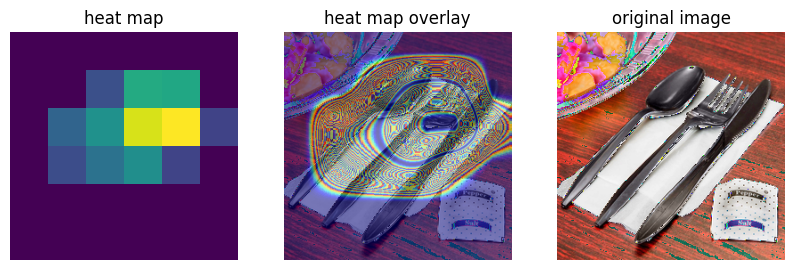

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(1,3,1)
plt.imshow(cam.cpu().permute(1,2,0))
plt.title("heat map")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(overlay_mask(img, cam_, alpha=0.5))
plt.title("heat map overlay")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(img)
plt.title("original image")
plt.axis("off")
plt.show()